In [ ]:
### To-Do
# X) make fit_function general enough for pswarms optimization -> dropout rate, layers, nodes, etc
# 1) put all this in a script
# 2) write function that runs fit_function ~5 times and keeps ensemble + best
# 3) implement pyswarms optimization
# X) e_sig vs (1-e_bkg) plot
# -) ... 
# N) k-fold validation

In [1]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2
from keras.models import load_model
from keras.backend import manual_variable_initialization 
import json

manual_variable_initialization(True)

from lbn import LBN, LBNLayer

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


In [2]:
import sys, os
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

topDir = '/home/btannenw/Desktop/ML/dihiggsMLProject/lorentzBoostNetwork/'

In [3]:
#*** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

Dihiggs file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/pp2hh4b_500kEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv
QCD file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/ppTo4b_2MEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv


(array([3.3195e+04, 4.0870e+04, 2.5949e+04, 1.1225e+04, 3.8130e+03,
        1.1030e+03, 2.6100e+02, 5.6000e+01, 5.0000e+00, 4.0000e+00]),
 array([ 4. ,  4.9,  5.8,  6.7,  7.6,  8.5,  9.4, 10.3, 11.2, 12.1, 13. ]),
 <a list of 10 Patch objects>)

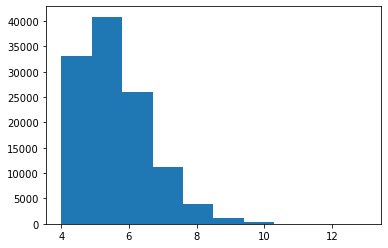

In [4]:
plt.hist(qcd_raw.nJets, bins=10)

In [5]:
# *** 2. Make mix of dihiggs and QCD for specified variables
jetLabels = ['1','2','3','4','5','6','7','8']
jetVariables = ['energy', 'px', 'py', 'pz']
variables_jetVects = ['jet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]

# *** 2. Split testing and training
jetVects_data_train, jetVects_data_test, jetVects_labels_train, jetVects_labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables_jetVects, testingFraction)

N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [6]:
# *** 2. Create jet vector inputs
def returnJetVectorInputsToLBN(_df, _jetType='jet', _nJets=4):
    
    #flattened
    _allVectorsFlattened = None
    _var = [_jetType+'{}_energy', _jetType+'{}_px', _jetType+'{}_py', _jetType+'{}_pz']
    
    for i in range(1, _nJets + 1):
        _varN = [x.format(i) for x in _var]
        _jetNData = _df[ _varN ].astype(np.float32)
        _vectN = [list(x) for x in _jetNData.values]
        
        if _allVectorsFlattened == None:
            _allVectorsFlattened = _vectN
        else:
            _allVectorsFlattened = [ x + y for x,y in zip(_allVectorsFlattened, _vectN) ]

    return np.array(_allVectorsFlattened)
    

nJets = 8
jetType = 'jet'
trainVectorsByEvent = returnJetVectorInputsToLBN( jetVects_data_train, jetType, nJets)
testVectorsByEvent  = returnJetVectorInputsToLBN( jetVects_data_test, jetType, nJets)

trainLabelsByEvent = np.array([[0.,1.] if x ==0 else [1.,0.] for x in jetVects_labels_train.isSignal]).astype(np.float32)
testLabelsByEvent  = np.array([[0.,1.] if x ==0 else [1.,0.] for x in jetVects_labels_test.isSignal]).astype(np.float32)

print(np.shape(trainVectorsByEvent))

(136749, 32)


In [7]:
# *** 3A. Define LBN model and train
def createModelLBN( user_hyperparameters={}, _weightsDir=''):
    """make lbn model"""
    
    _hyperparameters = {'nLBNParticles':            5,
                       'nodesInFirstHiddenLayer':  80, 
                       'nodesInSecondHiddenLayer': 256, 
                       'hiddenActivation':        'relu', 
                       'outputActivation':        'sigmoid', 
                       'lossFunction':            'binary_crossentropy'
                       }

    print(type(user_hyperparameters), user_hyperparameters)
    print("++ Setting hyperparameters...")
    for hp in _hyperparameters.keys():
        if hp in user_hyperparameters.keys():
            _hyperparameters[hp] = user_hyperparameters[hp] 
        
        print("{} = {}".format(hp, _hyperparameters[hp]))
    
    
    #init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=123)
 
    features = ["E", "pt", "eta", "phi", "m", "pair_dr"]
    lbn_layer = LBNLayer(n_particles= _hyperparameters['nLBNParticles'], boost_mode="pairs", features=features)
    
    
    metrics = [
        tf.keras.metrics.categorical_accuracy,
        tf.keras.metrics.AUC(name='auc'),
    ]
        
    l2_reg = tf.keras.regularizers.l2(1e-4)
    
    dense_kwargs_IML = dict(
        activation="selu",
        kernel_initializer=tf.keras.initializers.lecun_normal(),
        kernel_regularizer=l2_reg,
    )

    dense_kwargs = dict(
        activation = _hyperparameters['hiddenActivation'],
        kernel_initializer=tf.keras.initializers.lecun_normal(),
        kernel_regularizer=l2_reg,
    )

    _model = tf.keras.models.Sequential()

    #_model.add(LBNLayer(5, boost_mode=LBN.PAIRS, features=features))
    _model.add(lbn_layer)
    _model.add(tf.keras.layers.BatchNormalization(axis=1))


    _model.add(tf.keras.layers.Dense(_hyperparameters['nodesInFirstHiddenLayer'], **dense_kwargs))
    _model.add(tf.keras.layers.Dense(_hyperparameters['nodesInSecondHiddenLayer'], **dense_kwargs))


    #_model.add(tf.keras.layers.Dense(750, activation='relu'))#, kernel_regularizer=l2_reg))
    #_model.add(tf.keras.layers.Dense(256, activation='relu'))
    #_model.add(tf.keras.layers.Dropout(0.2))
    
    #_model.add(tf.keras.layers.Dense(128, activation='relu'))
    #_model.add(tf.keras.layers.Dense(64, activation='relu'))
    #_model.add(tf.keras.layers.Dense(32, activation='relu'))

    _model.add(tf.keras.layers.Dense(2, activation=_hyperparameters['outputActivation'], kernel_regularizer=l2_reg))
        
    _model.compile(loss= _hyperparameters['lossFunction'],
                    optimizer='adam',
                    metrics = metrics
                 )
    
    if _weightsDir !='':
        
        local_dir = os.path.join(topDir, "lbn", "models", _weightsDir)
        modelfile = os.path.join(local_dir, _weightsDir)+'.hdf5'
        print("++ loading model from {}".format(modelfile))
        #<-- FIXME: this does not check if file exits
    
        _model.predict(np.empty([1,32]))
        _model.load_weights(modelfile)

        
    return _model, _hyperparameters

In [8]:
def fit_model(name, data=None, validation_data=None, epochs=10, batch_size=512, model_hyperparams={}):
   
    # *** 0. Create model
    _model, _hyperparameters = createModelLBN(model_hyperparams)

    # *** 1. Define output directory
    model_dir = os.path.join(topDir, "lbn", "models", name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # *** 2. Define callbacks for training
    fit_callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(model_dir, name)+'.hdf5',
            save_best_only=True,
            save_weights_only=True,
            monitor="val_auc",
            mode="max",
            #monitor="val_loss",
            #mode="min",
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_auc",
            mode="max",
            #monitor='val_loss', 
            #mode='min', 
            verbose=1, 
            patience=100, 
            min_delta=.0025,
        ),
    ]

    # *** 3. Safety checks for data
    if data is None:
        data = (trainVectorsByEvent, trainLabelsByEvent)
    if validation_data is None:
        validation_data = (testVectorsByEvent, testLabelsByEvent)

        
    # *** 4. Fit!!
    print('++ Begin model training\n')
    _history = _model.fit(data[0], data[1],
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=fit_callbacks,
    )

    
    # *** 5. Save hyperparameters
    hp_filename=os.path.join(model_dir, name)+'_hyperparameters.json'
    with open(hp_filename, 'w') as outfile:
        json.dump( _hyperparameters, outfile)
    
    
    return _model, _history


def load_model(_modelDirectory):
    """load previously created model"""
    
    # *** 0. Get hyperparameters
    local_dir = os.path.join(topDir, "lbn", "models", _modelDirectory)
    hp_file = os.path.join(local_dir, _modelDirectory)+'_hyperparameters.json'
    print("++ loading hyperparameters from {}".format(hp_file))
    
    with open(hp_file, 'r') as infile:
        _hyperparameters = json.load(infile)
        
    # *** 1. Create model
    _model, _hyperparameters = createModelLBN(_hyperparameters, _modelDirectory)

    return _model

In [9]:
# *** 3A. Do things the proper, functional way

modelName = 'model_10TrainEpochs'

model, history = fit_model(name=modelName, data=(trainVectorsByEvent, trainLabelsByEvent), 
                          validation_data=(testVectorsByEvent, testLabelsByEvent), epochs=10, batch_size=400)

best_model = load_model( modelName )


<class 'dict'> {}
++ Setting hyperparameters...
nLBNParticles = 5
nodesInFirstHiddenLayer = 80
nodesInSecondHiddenLayer = 256
hiddenActivation = relu
outputActivation = sigmoid
lossFunction = binary_crossentropy
++ Begin model training

Train on 136749 samples, validate on 58608 samples
Epoch 1/10
136749/136749 [==============================] - 10s 75us/sample - loss: 0.6018 - categorical_accuracy: 0.6910 - auc: 0.7662 - val_loss: 0.5546 - val_categorical_accuracy: 0.7297 - val_auc: 0.8111
Epoch 2/10
136749/136749 [==============================] - 6s 47us/sample - loss: 0.5359 - categorical_accuracy: 0.7434 - auc: 0.8257 - val_loss: 0.5171 - val_categorical_accuracy: 0.7564 - val_auc: 0.8392
Epoch 3/10
136749/136749 [==============================] - 7s 48us/sample - loss: 0.5074 - categorical_accuracy: 0.7637 - auc: 0.8458 - val_loss: 0.4970 - val_categorical_accuracy: 0.7704 - val_auc: 0.8529
Epoch 4/10
136749/136749 [==============================] - 7s 48us/sample - loss: 0.4926 

In [ ]:
# *** 3B. Do things "by hand"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=.001)
mc = ModelCheckpoint('best_model.hdf5', #filepath=os.path.join(model_dir, name),
                    monitor="val_loss", mode='min', save_weights_only=True, save_best_only=True)
 

#model = createModelLBN(_outputActivation='softmax') # 1.77+/0.04, 1.84 +/- 0.06
model2 = createModelLBN(_outputActivation='sigmoid') # 1.81+/0.06

history = model2.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=50, validation_data = (testVectorsByEvent, testLabelsByEvent), batch_size=400, callbacks=[es, mc])
#history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=10, validation_data = (testVectorsByEvent, testLabelsByEvent))
print(model2.count_params())

# load the saved model
#model_best = model.load_weights('best_model.h5')

In [ ]:
# *** 3C. Define low-level NN using jet vectors for comparison
model_nn = tf.keras.models.Sequential()
nInputNodes = len(trainVectorsByEvent[0]) 
#model.add(Dense(100, input_dim=nInputNodes, activation='relu'))

model_nn.add(tf.keras.layers.Dense(128, input_dim = nInputNodes, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(BatchNormalization())

model_nn.add(tf.keras.layers.Dense(64, activation='relu'))
model_nn.add(tf.keras.layers.Dense(32, activation='relu'))
model_nn.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model_nn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_nn = model_nn.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=50, validation_data = (testVectorsByEvent, testLabelsByEvent), batch_size=400)
#history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=10, validation_data = (testVectorsByEvent, testLabelsByEvent))
print(model_nn.count_params())

In [10]:
best_model = load_model('model_10TrainEpochs')

# *** 4. Do some very specific evaluation based on pure samples
hh_data_test, hh_labels_test, qcd_data_test, qcd_labels_test = returnTestSamplesSplitIntoSignalAndBackground(testVectorsByEvent, testLabelsByEvent)

pred_hh = best_model.predict(np.array(hh_data_test))
pred_qcd = best_model.predict(np.array(qcd_data_test))

++ loading hyperparameters from /home/btannenw/Desktop/ML/dihiggsMLProject/lorentzBoostNetwork/lbn/models/model_10TrainEpochs/model_10TrainEpochs_hyperparameters.json
<class 'dict'> {'nLBNParticles': 5, 'nodesInFirstHiddenLayer': 80, 'nodesInSecondHiddenLayer': 256, 'hiddenActivation': 'relu', 'outputActivation': 'sigmoid', 'lossFunction': 'binary_crossentropy'}
++ Setting hyperparameters...
nLBNParticles = 5
nodesInFirstHiddenLayer = 80
nodesInSecondHiddenLayer = 256
hiddenActivation = relu
outputActivation = sigmoid
lossFunction = binary_crossentropy
++ loading model from /home/btannenw/Desktop/ML/dihiggsMLProject/lorentzBoostNetwork/lbn/models/model_10TrainEpochs/model_10TrainEpochs.hdf5
(58608, 2)


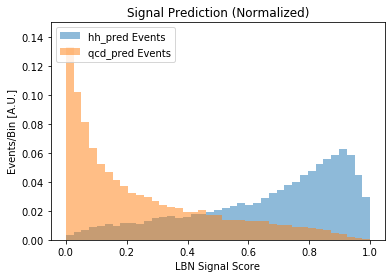

In [11]:
_nBins = 40
predictionResults = {'hh_pred':pred_hh[:,0], 'qcd_pred':pred_qcd[:,0]}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'LBN Signal Score', 0, 1, _nBins, _yMax = 5, _normed=True, _savePlot=False )


In [12]:
# *** 4. Get best cut value for ff-NN assuming some minimal amount of signal
returnBestCutValue('ff-NN', pred_hh[:,0].copy(), pred_qcd[:,0].copy(), _minBackground=200, _testingFraction=testingFraction)

23724 34884
nSig = 986.8223999999999 , nBkg = 419772.7 with significance = 1.5231122240688224 +/- 0.060279280127186516 for ff-NN score > 0.9088630351153287


(1.5231122240688224, 0.9088630351153287)

In [ ]:
# *** 5. Get signifiance for any user-specified NN score cut value
lumiscale_hh  = getLumiScaleFactor(testingFraction, True)
lumiscale_qcd = getLumiScaleFactor(testingFraction, False)
cut = 0.81
_nSignal = sum( value > cut for value in pred_hh)*lumiscale_hh
_nBackground = sum( value > cut for value in pred_qcd)*lumiscale_qcd

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

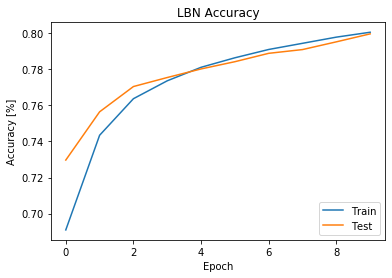

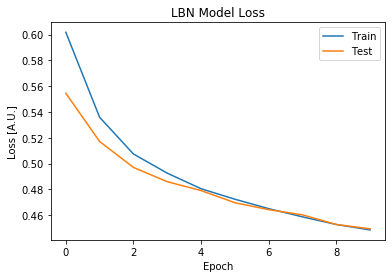

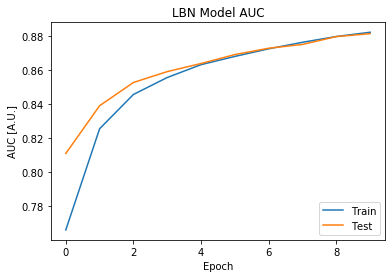

In [13]:
# *** 6. Make some training diagnostic plots
makeHistoryPlots( history, ['categorical_accuracy', 'loss', 'auc'], 'LBN')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lbn_layer (LBNLayer)         multiple                  80        
_________________________________________________________________
batch_normalization (BatchNo multiple                  140       
_________________________________________________________________
dense (Dense)                multiple                  2880      
_________________________________________________________________
dense_1 (Dense)              multiple                  20736     
_________________________________________________________________
dense_2 (Dense)              multiple                  514       
Total params: 24,350
Trainable params: 24,280
Non-trainable params: 70
_________________________________________________________________


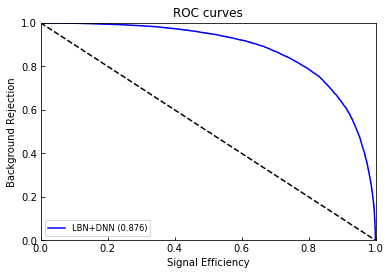

In [15]:
# plot the ROC cuves, i.e., background rejection (1 - eff_bkg) vs signal efficiency
testPredsByEvent = best_model.predict(testVectorsByEvent.copy())
makeEfficiencyCurves( dict(label="LBN+DNN", labels=testLabelsByEvent, prediction=testPredsByEvent, color="blue"))